In [1]:
from simulation import dataGenTrainer, plot_jointdist, plot_testdata, get_dataloader, ClassifierTrainer, concatenate, make_dummy_data
from sklearn.model_selection import train_test_split

from matplotlib.colors import ListedColormap

from utils import save_data, load_data, color_palette_to_cmap

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import AverageMeter

import copy
from attacker import LinfPGDAttack
import pandas as pd
import torch
import torch.nn.functional as F

import matplotlib
from scipy import stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from pathlib import Path
import random
from training import structured_prune
from training.trades import trades_loss

In [2]:
random_seed = 999

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
def generate_adv(net, test_loader, device, epsilon=1.0, alpha=0.01, k=7):
    net.eval()
    adv = LinfPGDAttack(net, epsilon=epsilon, alpha=alpha, k=k)
    
    advs = None
    correct_ys = None
    total = None
    total_ys = None
    perturbs = None
    succ_perturbs = None
    for X, y in test_loader:
        adv_x = adv.perturb(X.to(device), y.long().to(device))
        perturbs = concatenate(perturbs, (adv_x - X.to(device)).detach().cpu().numpy())
        out = net(adv_x)
        out = F.softmax(out, dim=1)
        _, predicted = out.max(1)
        idx = ~predicted.eq(y.to(device))
        
        succ_perturbs = concatenate(succ_perturbs, (adv_x[idx] - X[idx].to(device)).detach().cpu().numpy())
        advs = concatenate(advs, adv_x[idx].detach().cpu().numpy())
        correct_ys = concatenate(correct_ys, y[idx].detach().cpu().numpy())
        total = concatenate(total, adv_x.detach().cpu().numpy())
        total_ys = concatenate(total_ys, y.detach().cpu().numpy())
        
    adv_dataloader = get_dataloader(advs, correct_ys, drop_last=False, shuffle=False)
    total_adv_dataloader = get_dataloader(total, total_ys, drop_last=False, shuffle=False)
    
    return adv_dataloader, perturbs, succ_perturbs, advs, correct_ys, total_adv_dataloader
    
def accuracy2(net, test_loader, device):
    net.eval()
    correct = 0
    total_set = 0

    for X, y in test_loader:
        X = X.to(device)
        out = net(X)
        out = F.softmax(out, dim=1)
        _, predicted = out.max(1)
        idx = predicted.eq(y.to(device))
        correct += predicted.eq(y.to(device)).sum().item()

        total_set += X.size(0)

    benign_acc = correct / total_set
    print('accuracy: {0}'.format(benign_acc))
    return benign_acc, correct, total_set

def accuracy3(net, test_loader, device, epsilon=1.0, alpha=0.01, k=7):
    net.eval()
    correct = 0
    total_set = 0
    
    adv = LinfPGDAttack(net, epsilon=epsilon, alpha=alpha, k=k)

    for X, y in test_loader:
        adv_x = adv.perturb(X.to(device), y.long().to(device))
        
        out = net(adv_x)
        out = F.softmax(out, dim=1)
        _, predicted = out.max(1)
        idx = predicted.eq(y.to(device))
        correct += predicted.eq(y.to(device)).sum().item()

        total_set += X.size(0)

    benign_acc = correct / total_set
    print('accuracy: {0}'.format(benign_acc))
    return benign_acc, correct, total_set
    

def accuracy(net, test_loader, device, epsilon=1.0, alpha=0.01, k=7):
    net.eval()
    benign_correct = 0
    adv_correct = 0
    total_set = 0
    correct_label = None
    correct_list = None
    adv_list = None
    benign_softmax_list = None
    adversarial_softmax_list = None
    correct_softmax_list = None
    correct_adversarial_softmax_list = None
    
    adv = LinfPGDAttack(net, epsilon=epsilon,alpha=alpha, k=k)

    for X, y in test_loader:
        X = X.to(device)
        out = net(X)
        out = F.softmax(out, dim=1)
        benign_softmax_list = concatenate(benign_softmax_list, out.detach().cpu().numpy())
        _, predicted = out.max(1)
        idx = predicted.eq(y.to(device))
        benign_correct += predicted.eq(y.to(device)).sum().item()
        
        correct_softmax_list = concatenate(correct_softmax_list, out[idx].detach().cpu().numpy())
        correct_list = concatenate(correct_list, X[idx].detach().cpu().numpy())
        correct_label = concatenate(correct_label, y[idx].detach().cpu().numpy())
        
        adv_x = adv.perturb(X.to(device), y.long().to(device))
        
        perturbation = adv_x - X
        out = net(adv_x)
        out = F.softmax(out, dim=1)
        adversarial_softmax_list = concatenate(adversarial_softmax_list, out.detach().cpu().numpy())
        _, predicted = out.max(1)
        
        idx = predicted.eq(y.to(device))
        correct_adversarial_softmax_list = concatenate(correct_adversarial_softmax_list, out[idx].detach().cpu().numpy())
        
        adv_correct += predicted.eq(y.to(device)).sum().item()
        adv_list = concatenate(adv_list, perturbation.detach().cpu().numpy())
        
        total_set += X.size(0)

    benign_acc = benign_correct / total_set
    adv_acc = adv_correct / total_set
    print('benign accuracy: {0}\tadversarial accuracy: {1}'.format(benign_acc, adv_acc))
    return benign_acc, adv_acc, correct_list, correct_label, adv_list, correct_softmax_list, correct_adversarial_softmax_list, benign_softmax_list, adversarial_softmax_list

def create_onmanifold(classifier, vae, loader, device, filtering=True, optimize_tilde=False, epsilon=0.3, alpha=0.01, k=7):
    on_adv = OnManifold(classifier, vae.decoder, vae.encoder, device, eta=epsilon, k=k, alpha=alpha)
    
    on_adv_Xs = None
    on_ys = None
    on_zs = None
    fs = None
    pert = None
    
    for X, y in loader:
        X = X.reshape((X.shape[0], -1))
        z, z_pert, adv_x = on_adv.perturb(X.to(device), y.long().to(device))
        f_x = classifier(adv_x.reshape(adv_x.size(0), 1, 4, 4))
        
        pert = concatenate(pert, (adv_x - X.to(device)).detach().cpu().numpy())
        on_adv_Xs = concatenate(on_adv_Xs, adv_x.detach().cpu().numpy())
        on_zs = concatenate(on_zs, z_pert.detach().cpu().numpy())
        on_ys = concatenate(on_ys, y.detach().cpu().numpy())
        fs = concatenate(fs, f_x.detach().cpu().numpy())
    
    on_adv_loader = get_dataloader(on_adv_Xs.reshape((on_adv_Xs.shape[0], 1, 4, 4)), on_ys, drop_last=False, shuffle=False)
#     on_adv_acc, adv_acc, correct_list, correct_label, adv_list, benign_softmax_list, adversarial_softmax_list = accuracy(classifier, on_adv_loader, device)
    

#     if optimize_tilde:
#         # optimize to find z tilda
#         on_tilda_list = None

#         for i, (adv_x, adv_y) in enumerate(on_adv_loader):

#             z_loss = AverageMeter()
#             tilda = Tilda(adv_x.size(0)).to(device)
#             z_optimizer = torch.optim.Adam(tilda.parameters(), lr=0.09)
#             decoder = vae.encoder
#             decoder.eval()
#             for epoch in range(200):

#                 out = tilda(decoder)
#                 out = out.reshape((out.shape[0], 1, 4, 4))
#                 loss = torch.norm(adv_x.to(device) - out)

#                 z_loss.update(loss.item(), adv_y.size(0))

#                 z_optimizer.zero_grad()
#                 loss.backward()
#                 z_optimizer.step()

#             on_tilda_list = concatenate(on_tilda_list, tilda.z_tilde.data.detach().cpu().numpy())

#             if i % 20 == 0:
#                 print('z_loss: {0}'.format(z_loss.avg))
            
#         true_class = true_decision(on_tilda_list)
#     else:
    true_class = true_decision(on_zs)
    # check the definition of on-manifold
    
#     z_ = generator.vae.decoder(torch.tensor(on_adv_Xs, device=device))
#     true_class = true_decision(on_tilda_list)
#     idxs = true_class == on_ys

#     on_adv_Xs = on_adv_Xs[idxs]
#     on_ys = on_ys[idxs]
#     on_tilda_list = on_tilda_list[idxs]
    
    fs = fs.argmax(1)

    if filtering:
        # true decision boundary 를 넘어가지 않은 points
        idxs = true_class == on_ys
        print(len(idxs))

        filtered_X = on_adv_Xs[idxs]
        filtered_y = on_ys[idxs]
        filtered_z = on_zs[idxs]
        fs = fs[idxs]
        pert = pert[idxs]

        # classifier boundary를 넘어간 points
        idxs = (fs != filtered_y)
        on_adv_Xs = filtered_X[idxs]
        on_ys = filtered_y[idxs]
        on_zs = filtered_z[idxs]
        pert = pert[idxs]
        on_adv_loader = get_dataloader(on_adv_Xs.reshape((on_adv_Xs.shape[0], 1, 4, 4)), on_ys, drop_last=False, shuffle=False)
        return on_adv_Xs.reshape((on_adv_Xs.shape[0], 1, 4, 4)), on_ys, on_zs, on_adv_loader, pert
    
    else:
        on_adv_loader = get_dataloader(on_adv_Xs.reshape((on_adv_Xs.shape[0], 1, 4, 4)), on_ys, drop_last=False, shuffle=False)
        return on_adv_Xs.reshape((on_adv_Xs.shape[0], 1, 4, 4)), on_ys, on_zs, on_adv_loader, pert
    
    
class Tilda(torch.nn.Module):
    def __init__(self, batch_size):
        super(Tilda, self).__init__()
        z_tilde = np.random.normal(size=(batch_size,2))
        self.z_tilde = torch.nn.Parameter(torch.from_numpy(z_tilde).float(), requires_grad=True)
        
    def forward(self, decoder):
        return decoder(self.z_tilde)
    
def l2_distance(z_tilda):
    out = decoder(z_tilda.to(device))
    out = out.reshape((out.shape[0], 1, 4, 4))
    loss = (adv_x - out)**2
    loss = loss.mean()
    return loss

class OnManifold(object):
    def __init__(self, classifier, encoder, decoder, device, eta=0.3, k=7, alpha=0.0784):
        self.classifier = classifier
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
        self.eta = eta
        self.k = k
        self.alpha = alpha

    def perturb(self, X, y):
        z = self.encoder(X.to(self.device))
        zeta = z.detach().clone()

        for i in range(self.k):
            zeta.requires_grad_()
            with torch.enable_grad():
                x_tilde_pert = self.decoder(z + zeta)
                x_tilde_pert = x_tilde_pert.reshape((x_tilde_pert.shape[0], 1, 4, 4))
                pert_logits = self.classifier(x_tilde_pert)
                loss = F.cross_entropy(pert_logits, y.to(self.device), reduction="sum")
            grad = torch.autograd.grad(loss, [zeta])[0]
            z_pert = z.detach() + self.alpha * torch.sign(grad.detach())
            zeta = torch.clamp(z_pert - z, min=-self.eta, max=self.eta)
            x = self.decoder(z + zeta)

        return z, z_pert, x

def true_decision(x):
    probability = np.array([rv_list[i].pdf(x) for i in range(4)])
    return probability.argmax(axis=0)

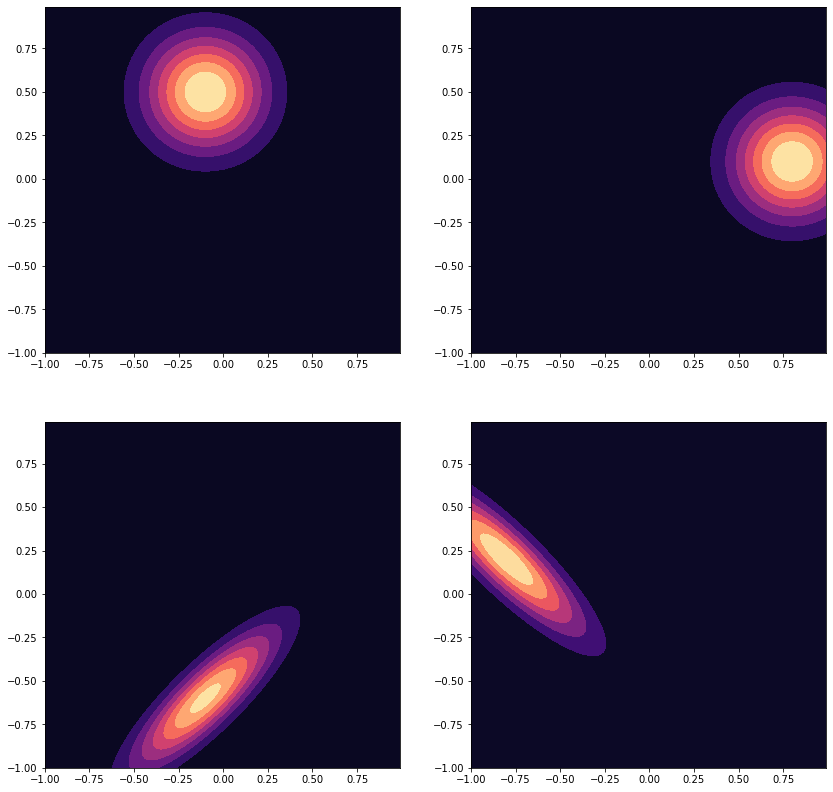

In [4]:
x, y = np.mgrid[-1:1:0.01, -1:1:.01]
pos = np.dstack((x, y))

rv1 = multivariate_normal(mean=[-0.1, 0.5], cov=[[0.05, 0],[0, 0.05]])
rv2 = multivariate_normal(mean=[0.8, 0.1], cov=[[0.05, 0],[0, 0.05]])
rv3 = multivariate_normal(mean=[-0.1, -0.6], cov=[[0.07, 0.06],[0.06, 0.07]])
rv4 = multivariate_normal(mean=[-0.8, 0.2], cov=[[0.08, -0.07],[-0.07, 0.08]])

fig, subplots = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(14)
subplots = subplots.reshape(-1)
subplots[0].contourf(x, y, rv1.pdf(pos), cmap='magma')
subplots[1].contourf(x, y, rv2.pdf(pos), cmap='magma')
subplots[2].contourf(x, y, rv3.pdf(pos), cmap='magma')
subplots[3].contourf(x, y, rv4.pdf(pos), cmap='magma')
plt.show()

In [5]:
dist_info = {
    0: {
        'mean': [-0.1, 0.5],
        'cov': [[0.05, 0],[0, 0.05]],
    },
    1: {
        'mean': [0.8, 0.1],
        'cov': [[0.05, 0],[0, 0.05]],
    },
    2: {
        'mean': [-0.1, -0.6],
        'cov': [[0.07, 0.06],[0.06, 0.07]],
    },
    3: {
        'mean': [-0.8, 0.2],
        'cov': [[0.08, -0.07],[-0.07, 0.08]],
    }
}

rv_list = [multivariate_normal(mean=dist_info[i]['mean'], cov=dist_info[i]['cov']) for i in range(4)]

In [6]:
CUDA_NUM = 4
device = 'cuda:%d' % CUDA_NUM

# cls = load_data( './simulation/simulated_classifier.pkl')

generator = load_data( './simulation/simulated_generator.pkl')


gen_x, gen_y = load_data('./simulation/Simulation/generated_data.pkl')
train_x, test_x, train_y, test_y = train_test_split(gen_x, gen_y, test_size=1/7, random_state=42)
train_x, test_x = train_x.reshape((train_x.shape[0], 1, 4, 4)), test_x.reshape((test_x.shape[0], 1, 4, 4))

train_loader = get_dataloader(train_x, train_y)
test_loader = get_dataloader(test_x, test_y)

cls = ClassifierTrainer(CUDA_NUM, train_loader, test_loader, [32, 64], EPOCH=30)
cls.classifier.load_state_dict(torch.load('./simulation/Simulation/simulated_clf.pt'))
classifier = cls.classifier
classifier.to(device)

vae = generator.vae
vae.load_state_dict(torch.load('./simulation/Simulation/simulated_vae.pt'))
vae.to('cuda:4')

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=16, bias=True)
    (relu): LeakyReLU(negative_slope=0.2)
    (meanfc): Linear(in_features=16, out_features=16, bias=True)
    (varfc): Linear(in_features=16, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (in_fc): Linear(in_features=16, out_features=16, bias=True)
    (fc1): Linear(in_features=16, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=2, bias=True)
    (relu): LeakyReLU(negative_slope=0.2)
  )
)

In [8]:
x_min, x_max = generator.X[:, 0].min() - 1, generator.X[:, 0].max() + 1
y_min, y_max = generator.X[:, 1].min() - 1, generator.X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))

yhat = true_decision(grid)

zz = yhat.reshape(xx.shape)

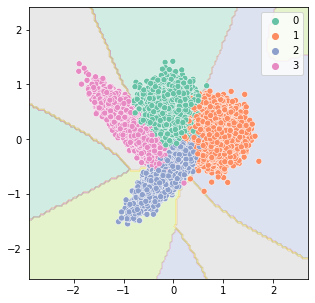

In [9]:
from matplotlib.colors import ListedColormap
cmap = color_palette_to_cmap(sns.color_palette("Set2"))
plt.figure(figsize=(5,5))
plt.contourf(xx, yy, zz, cmap=cmap, alpha=0.3)
sns.scatterplot(x=generator.X[:,0], y=generator.X[:,1], hue=generator.y.astype(np.int32), palette=sns.color_palette("Set2", 4))

In [11]:
gen_x, gen_y = generator.generate_data()
save_data((gen_x, gen_y), './simulation/Simulation/', 'generated_data.pkl')

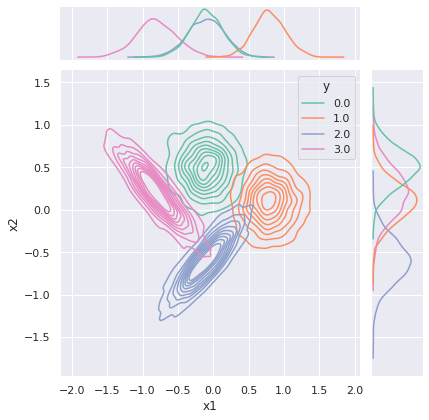

In [133]:
plot_jointdist(generator.X, generator.y, numbers=10000)

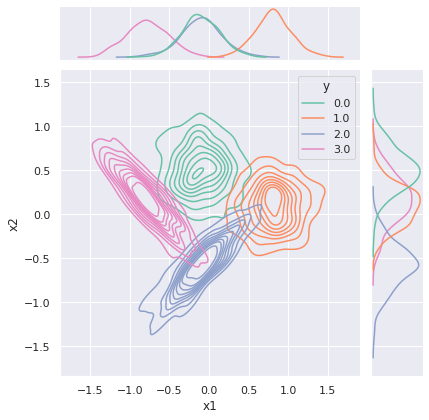

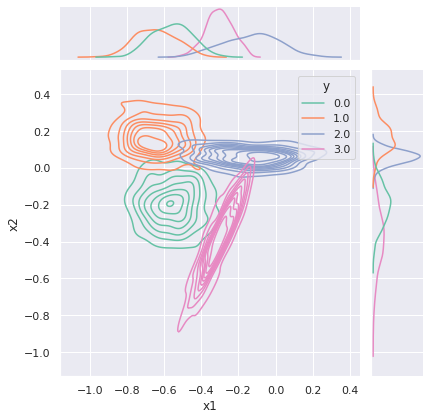

In [10]:
plot_jointdist(generator.X, generator.y)
plot_jointdist(gen_x, gen_y, idxs=[0,1])

## for plot decision boundaries

In [27]:
x_min, x_max = generator.X[:, 0].min() - 1, generator.X[:, 0].max() + 1
y_min, y_max = generator.X[:, 1].min() - 1, generator.X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.03),
                     np.arange(y_min, y_max, 0.03))

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))

yhat = true_decision(grid)

zz = yhat.reshape(xx.shape)

In [9]:
matplotlib.rcParams.update({'legend.fontsize': 13})

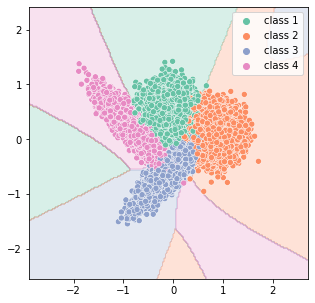

In [28]:
from matplotlib.colors import ListedColormap
cmap = color_palette_to_cmap(sns.color_palette("Set2",4))

fig,ax = plt.subplots(figsize=(5,5))
plt.contourf(xx, yy, zz, cmap=cmap, alpha=0.25)
sns.scatterplot(x=generator.X[:,0], y=generator.X[:,1], hue=(generator.y + 1).astype(np.int32), palette=sns.color_palette("Set2", 4), ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['class 1', 'class 2', 'class 3', 'class 4'])

plt.savefig('./figures/sim_orig.png', dpi=150, bbox_inches='tight')

In [10]:
epsilon = 0.1
k = 15
alpha=0.01

filtered_X, filtered_y, filtered_z, on_adv_loader, pert = create_onmanifold(classifier, vae, train_loader, device, epsilon=epsilon, k=k, alpha=alpha, filtering=True)

60000


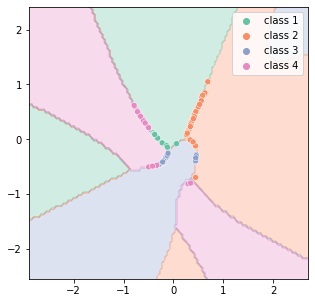

In [25]:
cmap = ListedColormap(sns.color_palette("Set2", 4).as_hex())
fig,ax = plt.subplots(figsize=(5,5))
plt.contourf(xx, yy, zz, cmap=cmap, alpha=0.3)
sns.scatterplot(x=filtered_z.reshape((filtered_z.shape[0], -1))[:,0], y=filtered_z.reshape((filtered_z.shape[0], -1))[:,1], hue=filtered_y.astype(np.int32), palette=sns.color_palette("Set2", 4))
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['class 1', 'class 2', 'class 3', 'class 4'])

plt.savefig('./figures/sim_on.png', dpi=150, bbox_inches='tight')

### train classifier

In [17]:
gen_x, gen_y = load_data('./simulation/Simulation/generated_data.pkl')
train_x, test_x, train_y, test_y = train_test_split(gen_x, gen_y, test_size=1/7, random_state=42)
train_x, test_x = train_x.reshape((train_x.shape[0], 1, 4, 4)), test_x.reshape((test_x.shape[0], 1, 4, 4))

train_loader = get_dataloader(train_x, train_y)
test_loader = get_dataloader(test_x, test_y)

In [16]:
cls = ClassifierTrainer(CUDA_NUM, train_loader, test_loader, [32, 64], EPOCH=30)
cls.train()
torch.save(cls.best_model.cpu().state_dict(), './simulation/Simulation/simulated_clf.pt')
classifier = cls.classifier
classifier.to(device)

epoch: 0	round: 0	loss: 1.3877665996551514
epoch: 0	round: 100	loss: 0.18070319294929504
epoch: 0	round: 200	loss: 0.04480903595685959
epoch: 0	round: 300	loss: 0.07013124972581863
epoch: 0	round: 400	loss: 0.03692502900958061
epoch: 0	round: 0	loss: 0.08104077726602554
epoch 0 summary: train_loss: 0.18155775706370672, test_loss: 0.10371300610303878
epoch: 1	round: 0	loss: 0.14443808794021606
epoch: 1	round: 100	loss: 0.046188823878765106
epoch: 1	round: 200	loss: 0.04320723935961723
epoch: 1	round: 300	loss: 0.06349962204694748
epoch: 1	round: 400	loss: 0.059822916984558105
epoch: 1	round: 0	loss: 0.1185823306441307
epoch 1 summary: train_loss: 0.08838380327423413, test_loss: 0.09755993664264678
epoch: 2	round: 0	loss: 0.08571586012840271
epoch: 2	round: 100	loss: 0.13975565135478973
epoch: 2	round: 200	loss: 0.07489342987537384
epoch: 2	round: 300	loss: 0.13112297654151917
epoch: 2	round: 400	loss: 0.04315832629799843
epoch: 2	round: 0	loss: 0.0577266626060009
epoch 2 summary: train_

In [15]:
CUDA_NUM = 4
device = 'cuda:%d' % CUDA_NUM

In [ ]:
cls = ClassifierTrainer(CUDA_NUM, train_loader, test_loader, [32, 64], EPOCH=30)
cls.train()

In [18]:
cls = ClassifierTrainer(CUDA_NUM, train_loader, test_loader, [32, 64], EPOCH=30)
cls.classifier.load_state_dict(torch.load('./simulation/Simulation/simulated_clf.pt'))
classifier = cls.classifier
classifier.to(device)

SimpleClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

### off-manifold

In [19]:
epsilon = 0.1
k= 7
alpha=0.01


off_adv_loader, perturbs, succ_perturbs, adv_list, y_list, total_off_adv_loader = generate_adv(classifier, test_loader, device, epsilon=epsilon, alpha=alpha, k=k)

In [24]:
off_norm = np.linalg.norm(succ_perturbs.reshape((succ_perturbs.shape[0], -1)), axis=1)

### on-manifold

In [19]:
vae = generator.vae
vae.to('cuda:4')

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=16, bias=True)
    (relu): LeakyReLU(negative_slope=0.2)
    (meanfc): Linear(in_features=16, out_features=16, bias=True)
    (varfc): Linear(in_features=16, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (in_fc): Linear(in_features=16, out_features=16, bias=True)
    (fc1): Linear(in_features=16, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=2, bias=True)
    (relu): LeakyReLU(negative_slope=0.2)
  )
)

In [55]:
epsilon = 0.1
k = 15
alpha=0.01


filtered_X, filtered_y, filtered_z, on_adv_loader, on_pert = create_onmanifold(classifier, vae, train_loader, device, epsilon=epsilon, k=k, alpha=alpha, filtering=True)
# save_data(on_adv_loader, './simulation/Simulation/', 'on_adv_eps%s_filtered.pkl' % str(epsilon).replace('.','_'))

print(filtered_X.shape)

60000
(0, 1, 4, 4)


In [49]:
epsilon = 0.3
k = 7
alpha=0.01


filtered_X, filtered_y, filtered_z, on_adv_loader, on_pert = create_onmanifold(classifier, vae, test_loader, device, filtering=True)

10000


In [135]:
def trades_iter(model, optimizer, criterion, data_loader, device, comp_ratio=0., step_size=0.01, epsilon=0.07, perturb_steps=7, beta=1.):
    model.train()
    iteration_loss = AverageMeter()
    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.long().to(device)

        optimizer.zero_grad()
        
        
        # calculate robust loss
        loss = trades_loss(model=model,
                           x_natural=X,
                           y=y,
                           optimizer=optimizer,
                           device=device,
                           step_size=step_size,
                           epsilon=epsilon,
                           perturb_steps=perturb_steps,
                           beta=beta)
        
        
        iteration_loss.update(loss.item(), X.size(0))
        
        loss.backward()
        optimizer.step()

        if comp_ratio > 0:
            mask, lam = structured_prune(model, comp_ratio)
    if comp_ratio > 0:
        mask, lam = structured_prune(model, comp_ratio)
    return iteration_loss.avg

def test_iter(model, data_loader, device, check_adv=False, epsilon=0.3, alpha=0.0073, k=7):
    model.eval()
    normal_acc = AverageMeter()

    if check_adv:
        adv = LinfPGDAttack(model, epsilon=epsilon, alpha=alpha, k=k)
        off_acc = AverageMeter()

    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        output = model(X)

        out = F.softmax(output, dim=1)
        _, predicted = out.max(1)
        idx = predicted.eq(y)

        acc = idx.sum().item() / X.size(0)
        normal_acc.update(acc)

        if check_adv:
            adv_x = adv.perturb(X, y.long())

            out = model(adv_x)
            out = F.softmax(out, dim=1)
            _, predicted = out.max(1)
            idx = predicted.eq(y)

            acc = idx.sum().item() / X.size(0)
            off_acc.update(acc)

    if check_adv:
        return normal_acc.avg, off_acc.avg
    else:
        return normal_acc.avg

def train_trades(comp_ratio, loader, test_loader, off_adv_loader, on_adv_loader, onadv_testloader=None, retrain=False, EPOCHs=10, epsilon=0.07, k=7, alpha=0.01):
    cls = ClassifierTrainer(CUDA_NUM, loader, test_loader, [32, 64], EPOCH=EPOCHs)
    sparse_coding = False
    if comp_ratio > 0:
        sparse_coding = True
    cls_path = Path('./simulation/Simulation/trades_clf_%s.pt'%(str(comp_ratio).replace('.', '_')))
    
    print(cls_path)
    
    if cls_path.exists() and not retrain:
        cls.classifier.load_state_dict(torch.load(cls_path))
        classifier = cls.classifier
        
    else:
        classifier = cls.classifier
        classifier.load_state_dict(torch.load('./simulation/Simulation/simulated_clf.pt'))
        
        classifier.to(device)
        optimizer = torch.optim.SGD(classifier.parameters(), lr=0.1, momentum=0.9)
        criterion = torch.nn.CrossEntropyLoss()
        
        
        for epoch in range(EPOCHs):
            train_loss = trades_iter(classifier, optimizer, criterion, train_loader, device, comp_ratio, step_size=alpha, epsilon=epsilon, perturb_steps=k, beta=1.)
            val_acc = test_iter(classifier, test_loader, device)
            
            if (epoch + 1) % 5 == 0:
                print('Epoch {}\tTrain loss: {:.4f}\tValidation accuracy: {:.4f}'.format(epoch + 1, train_loss, val_acc))
            
        torch.save(classifier.cpu().state_dict(), cls_path)
    
    classifier.to(device)
    
    
    benign_acc, benign_correct, benign_total = accuracy2(classifier, test_loader, device)
    off_acc, off_correct, off_total = accuracy3(classifier, test_loader, device, epsilon=epsilon, alpha=alpha, k=k)
    on_acc, on_correct, on_total = accuracy2(classifier, on_adv_loader, device)
    
    normal_acc = (benign_correct + on_correct) / (benign_total + on_total)
    
    
    return benign_acc, off_acc, on_acc, normal_acc, benign_correct, off_correct, on_correct, benign_total, off_total, on_total
    
#     benign_acc, adv_acc, _, _, adv_list, benign_softmax_list, adversarial_softmax_list, total_benign_softmax_list, total_adversarial_softmax_list = accuracy(classifier, test_loader, device, epsilon=epsilon, alpha=alpha, k=k)
#     onadv_acc, _, _, _, _, onadv_softmax_list, _, total_onadv_softmax_list, _ = accuracy(classifier, onadv_testloader, device, epsilon=epsilon, alpha=alpha, k=k)
    
#     return benign_acc, adv_acc, onadv_acc

In [136]:
def acc_per_sparsity(train_type, loader, test_loader, off_adv_loader, on_adv_loader, EPOCHs=10, retrain_models=False, onadv_loader=None, sparsity_ratio=0.9, epsilon=1.0, alpha=0.01, k=7):
    cls = ClassifierTrainer(CUDA_NUM, loader, test_loader, [32, 64], EPOCH=EPOCHs)
    sparse_coding = False
    if sparsity_ratio > 0:
        sparse_coding = True
    cls_path = Path('./simulation/Simulation/%s_clf_%s.pt'%(train_type, str(sparsity_ratio).replace('.', '_')))
    if sparsity_ratio == 0. and train_type == 'normal':
        cls_path = Path('./simulation/Simulation/simulated_clf.pt')
        
    print(cls_path)
        
    if cls_path.exists() and not retrain_models:
        cls.classifier.load_state_dict(torch.load(cls_path))
        classifier = cls.classifier
    else:
        cls.classifier.load_state_dict(torch.load('./simulation/Simulation/simulated_clf.pt'))
        if train_type == 'off_at':
            cls.train(sparse_coding, sparsity_ratio, AT=True, epsilon=epsilon, alpha=alpha, k=k)
        elif train_type =='onoff_at':
            cls.train(sparse_coding, sparsity_ratio, onoff=True, onadv_loader=onadv_loader, epsilon=epsilon, alpha=alpha, k=k)
        else:
            cls.train(sparse_coding, sparsity_ratio)
        classifier = cls.best_model
        torch.save(classifier.cpu().state_dict(), cls_path)

    classifier.to(device)
    
    benign_acc, benign_correct, benign_total = accuracy2(classifier, test_loader, device)
    off_acc, off_correct, off_total = accuracy3(classifier, test_loader, device, epsilon=epsilon, alpha=alpha, k=k)
    on_acc, on_correct, on_total = accuracy2(classifier, on_adv_loader, device)
    
    normal_acc = (benign_correct + on_correct) / (benign_total + on_total)
    
    
    
    
    return benign_acc, off_acc, on_acc, normal_acc, benign_correct, off_correct, on_correct, benign_total, off_total, on_total

#     benign_acc, adv_acc, _, _, adv_list, benign_softmax_list, adversarial_softmax_list, total_benign_softmax_list, total_adversarial_softmax_list = accuracy(classifier, test_loader, device, epsilon=epsilon, alpha=alpha, k=k)
#     onadv_acc, _, _, _, _, onadv_softmax_list, _, total_onadv_softmax_list, _ = accuracy(classifier, onadv_testloader, device, epsilon=epsilon, alpha=alpha, k=k)
    
#     return benign_acc, adv_acc, onadv_acc, adv_list, benign_softmax_list, adversarial_softmax_list, onadv_softmax_list, total_benign_softmax_list, total_adversarial_softmax_list, total_onadv_softmax_list

In [107]:
epsilon = 0.3
k= 7
alpha=0.01
sparsity_ratio = 0

normal_t1, normal_t3, normal_t2, normal_t1t2, _, _, _, _, _, _ = acc_per_sparsity('normal', train_loader, test_loader, off_adv_loader, on_adv_test_loader, EPOCHs, retrain_models=False, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
on_t1, on_t3, on_t2, on_t1t2, _, _, _, _, _, _ = acc_per_sparsity('on_at', train_loader, test_loader, off_adv_loader, on_adv_test_loader, EPOCHs, retrain_models=False, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
off_t1, off_t3, off_t2, off_t1t2, _, _, _, _, _, _ = acc_per_sparsity('off_at', train_loader, test_loader, off_adv_loader, on_adv_test_loader, EPOCHs, retrain_models=True, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
onoff_t1, onoff_t3, onoff_t2, onoff_t1t2, _, _, _, _, _, _ = acc_per_sparsity('onoff_at', train_loader, test_loader, off_adv_loader, on_adv_test_loader, EPOCHs, retrain_models=False, sparsity_ratio=sparsity_ratio, epsilon=epsilon, alpha=alpha, k=k)
trades_t1, trades_t3, trades_t2, trades_t1t2, _, _, _, _, _, _ = train_trades(sparsity_ratio, train_loader, test_loader, off_adv_loader, on_adv_test_loader, epsilon=epsilon, k=k, alpha=alpha)

simulation/Simulation/simulated_clf.pt
accuracy: 0.972
accuracy: 0.0
accuracy: 0.0
simulation/Simulation/on_at_clf_0.pt
accuracy: 0.9699
accuracy: 0.017579028527370855
accuracy: 0.81
simulation/Simulation/off_at_clf_0.pt
epoch: 0	round: 0	loss: 3.6786415576934814
epoch: 0	round: 100	loss: 0.7084528803825378
epoch: 0	round: 200	loss: 0.807042121887207
epoch: 0	round: 300	loss: 0.749026894569397
epoch: 0	round: 400	loss: 0.7184746265411377
epoch: 0	round: 0	loss: 0.3277958631515503
epoch 0 summary: train_loss: 0.8064291291554769, test_loss: 0.3517431916236877
epoch: 1	round: 0	loss: 0.8243158459663391
epoch: 1	round: 100	loss: 0.775455117225647
epoch: 1	round: 200	loss: 0.8159354329109192
epoch: 1	round: 300	loss: 0.8643967509269714
epoch: 1	round: 400	loss: 0.7002105712890625
epoch: 1	round: 0	loss: 0.47866734862327576
epoch 1 summary: train_loss: 0.7298754033088684, test_loss: 0.4510356719017029
epoch: 2	round: 0	loss: 0.6402084231376648
epoch: 2	round: 100	loss: 0.6918765902519226
epo